## setup

In [1]:
! pip install tensorflow numpy matplotlib torch torchvision pandas scikit-learn opencv-python

import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: C:\Program Files\Python311\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


## custom loss model

In [5]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Concatenate, Flatten, Dense, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
import sklearn
import sklearn.metrics
from PIL import Image



In [6]:
def build_simple_dtn(input_shape):
    # Inputs
    x_ref_input = Input(shape=input_shape, name='x_ref')
    eta_exp_input = Input(shape=input_shape, name='eta_exp')

    # Combine inputs along channel dimension
    x = Concatenate()([x_ref_input, eta_exp_input])  # Shape: (H, W, 6)

    # structure 1
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # structure 2
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # structure 3
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)


    # structure 4
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # # Crop to match the input shape
    # x = tf.keras.layers.Cropping2D(cropping=((2, 2), (2, 2)))(x)

    # structure 5
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # final layer 
    x = Conv2D(3, (1, 1), activation='sigmoid', padding='same', name='prediction')(x)  # Output 3 channels

    model = Model(
        inputs=[x_ref_input, eta_exp_input],
        outputs={"prediction": x, "x_ref_passthrough": x_ref_input}
    )

    # Return both the prediction and the input x_ref (as passthrough)
    #model = Model(inputs=[x_ref_input, eta_exp_input], outputs=[x, x_ref_input])

    # model = Model(inputs=[x_ref_input, eta_exp_input], outputs=x)
    return model


In [7]:
def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images)


print("Loading real datasets...")
x_ref = load_images_from_folder('dataset/reference')
eta_exp = load_images_from_folder('dataset/texture')
x_ren = load_images_from_folder('dataset/rendered')
print(x_ref.shape)

Loading real datasets...
(1030, 500, 500, 3)


In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

class IntersectionOverlayCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_ref_val, eta_exp_val, x_ren_val, save_dir='overlay_outputs_50_epochs', interval=1):
        super().__init__()
        self.x_ref_val = x_ref_val
        self.eta_exp_val = eta_exp_val
        self.x_ren_val = x_ren_val
        self.interval = interval
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.interval != 0:
            return

        output_dict = self.model.predict([self.x_ref_val, self.eta_exp_val])
        preds = output_dict["prediction"]


        # Compute intersection (where rendered and reference are nearly equal)
        intersection_mask = np.isclose(self.x_ren_val, self.x_ref_val, atol=1e-2)

        # Overlay: only keep intersecting pixels in prediction
        overlay_preds = np.where(intersection_mask, self.x_ref_val, preds)
        #overlay_preds = np.where(intersection_mask, preds, 0.0)

        # Visualize or save first few samples
        num_samples = min(3, len(preds))
        for i in range(num_samples):
            fig, axes = plt.subplots(1, 4, figsize=(16, 4))
            axes[0].imshow(self.x_ref_val[i])
            axes[0].set_title("x_ref")
            axes[1].imshow(self.x_ren_val[i])
            axes[1].set_title("x_ren")
            axes[2].imshow(preds[i])
            axes[2].set_title("prediction")
            axes[3].imshow(overlay_preds[i])
            axes[3].set_title("pred ∩ intersection")
            for ax in axes:
                ax.axis("off")

            plt.tight_layout()
            plt.savefig(os.path.join(self.save_dir, f"epoch_{epoch+1}_sample_{i+1}.png"))
            plt.close()


def masked_mse_only_on_diff(y_true, y_pred):
    # `y_pred` is just the output from 'prediction'
    # we will pull `x_ref` from the model's second output via `add_loss`

    # Use Keras backend to store global reference
    x_ref_tensor = tf.keras.backend.get_value(tf.keras.backend.learning_phase())  # placeholder
    raise NotImplementedError("You can't access the other output here directly")

# This is just to show that Keras doesn't allow cross-output access in a pure loss function
# So we use a custom training step instead — see next


class CustomModel(tf.keras.Model):
    def train_step(self, data):
        (x_ref, eta_exp), y_true = data

        with tf.GradientTape() as tape:
            outputs = self([x_ref, eta_exp], training=True)
            y_pred = outputs["prediction"]
            x_ref_passthrough = outputs["x_ref_passthrough"]

            # Calculate intersection mask
            epsilon = 1e-2
            mask = tf.cast(tf.abs(y_true - x_ref_passthrough) > epsilon, tf.float32)
            sq_diff = tf.square(y_true - y_pred)
            masked_sq_diff = sq_diff * mask
            loss = tf.reduce_sum(masked_sq_diff) / (tf.reduce_sum(mask) + 1e-8)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {"loss": loss}


def masked_mse_intersection_loss(y_true, y_pred):
    y_pred_img, x_ref = y_pred  # unpack model outputs
    x_ren = y_true  # the true rendered image

    epsilon = 1e-2
    mask = tf.abs(x_ren - x_ref) > epsilon
    mask = tf.cast(mask, tf.float32)

    sq_diff = tf.square(x_ren - y_pred_img)
    masked_sq_diff = sq_diff * mask
    denom = tf.reduce_sum(mask) + 1e-8

    return tf.reduce_sum(masked_sq_diff) / denom


def wrapper_loss(y_true, y_pred_outputs):
    return masked_mse_intersection_loss(y_true, y_pred_outputs)



# def masked_mse_outside_intersection(x_ref, x_ren, epsilon=1e-2):
#     def loss_fn(y_true, y_pred):
#         # Create a mask: where rendered and reference are NOT approximately equal
#         mask = tf.math.greater(tf.abs(x_ren - x_ref), epsilon)  # shape: (N, H, W, C)
#         mask = tf.cast(mask, tf.float32)

#         # Compute squared difference
#         sq_diff = tf.square(y_true - y_pred)

#         # Apply mask
#         masked_sq_diff = sq_diff * mask

#         # Avoid dividing by zero
#         denom = tf.reduce_sum(mask) + 1e-8

#         return tf.reduce_sum(masked_sq_diff) / denom  # Mean over masked elements
#     return loss_fn


In [9]:
base_model = build_simple_dtn(input_shape=(500, 500, 3))

model = CustomModel(inputs=base_model.inputs, outputs=base_model.output)

# Assuming x_ref, eta_exp, and x_ren are loaded with shape (N, H, W, 3)
# model = build_simple_dtn(input_shape=(500, 500, 3))


model.compile(optimizer='adam', metrics=['accuracy'])
# Uncomment the following line to use a standard MSE loss instead
# model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Use a small validation set to visualize overlays
callback = IntersectionOverlayCallback(
    x_ref_val=x_ref[1025:], 
    eta_exp_val=eta_exp[1025:], 
    x_ren_val=x_ren[1025:], 
    save_dir='overlay_outputs_50_epochs', 
    interval=1  # every epoch
)


history = model.fit(
    [x_ref[:1025], eta_exp[:1025]],
    x_ren[:1025],
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    callbacks=[callback]
)
            # callbacks=[ 
            #     tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
            # ]
model.save('models/k3_50epch_custom_loss_w_fit().h5')
# early stopping disable for structure 4

2025-07-14 15:50:37.696743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-14 15:50:37.697004: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2025-07-14 15:50:37.697070: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2025-07-14 15:50:37.697117: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared o

Epoch 1/50
58/58 [==============================] - 157s 3s/step - loss: 0.0260 - val_loss: 0.0000e+00 - val_prediction_accuracy: 0.0284 - val_x_ref_accuracy: 0.9853
Epoch 2/50
58/58 [==============================] - 155s 3s/step - loss: 0.0130 - val_loss: 0.0000e+00 - val_prediction_accuracy: 0.9796 - val_x_ref_accuracy: 0.9853
Epoch 3/50
58/58 [==============================] - 156s 3s/step - loss: 0.0071 - val_loss: 0.0000e+00 - val_prediction_accuracy: 0.9835 - val_x_ref_accuracy: 0.9853
Epoch 4/50
58/58 [==============================] - 156s 3s/step - loss: 0.0075 - val_loss: 0.0000e+00 - val_prediction_accuracy: 0.9849 - val_x_ref_accuracy: 0.9853
Epoch 5/50
58/58 [==============================] - 155s 3s/step - loss: 0.0062 - val_loss: 0.0000e+00 - val_prediction_accuracy: 0.9896 - val_x_ref_accuracy: 0.9853
Epoch 6/50
58/58 [==============================] - 155s 3s/step - loss: 0.0049 - val_loss: 0.0000e+00 - val_prediction_accuracy: 0.9899 - val_x_ref_accuracy: 0.9853
Epoc

#### Validation on val_dataset

In [10]:
print("Loading validation datasets...")
val_x_ref = load_images_from_folder('validation_dataset_clean/reference')
val_eta_exp = load_images_from_folder('validation_dataset_clean/texture')
val_x_ren = load_images_from_folder('validation_dataset_clean/rendered')
print(val_x_ref.shape)

Loading validation datasets...
(75, 500, 500, 3)


In [11]:
# Predict
preds = model.predict([val_x_ref, val_eta_exp])['prediction']

# Compute intersection (where rendered and reference are nearly equal)
intersection_mask = np.isclose(val_x_ren, val_x_ref, atol=1e-2)

# Overlay: only keep intersecting pixels in prediction
overlay_preds = np.where(intersection_mask, val_x_ref, preds)
# overlay_preds = np.where(intersection_mask, preds, 0.0)

avg_mse = sklearn.metrics.mean_squared_error(val_x_ren.ravel(), overlay_preds.ravel())


print("Average MSE: ", avg_mse)  

3/3 [==============================] - 3s 906ms/step
Average MSE:  0.00037035826


1/1 [==============================] - 0s 233ms/step


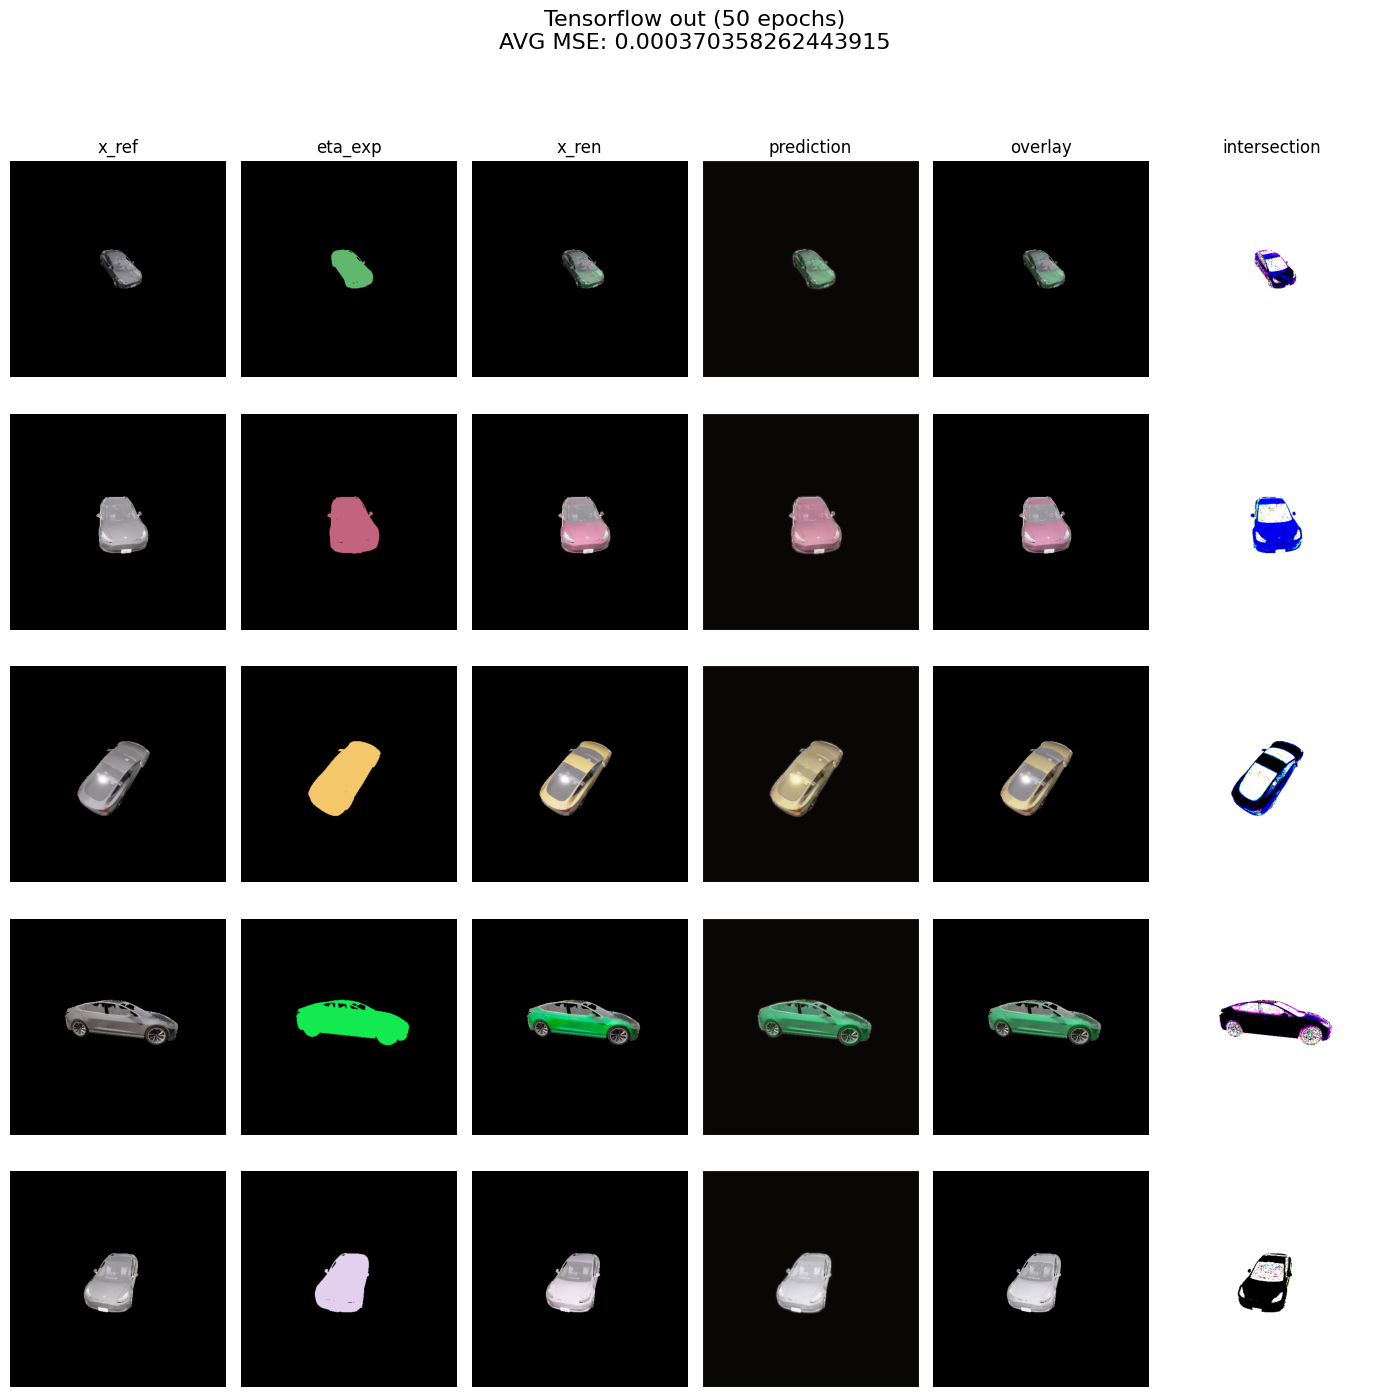

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Predict
preds = model.predict([x_ref[1025:], eta_exp[1025:]])['prediction']

intersection_mask = np.isclose(x_ren[1025:], x_ref[1025:], atol=1e-2)
overlay_preds = np.where(intersection_mask, x_ref[1025:], preds)

num_samples = 5
titles = ["x_ref", "eta_exp", "x_ren", "prediction", "overlay", "intersection"]

plt.figure(figsize=(14, num_samples * 3))

for i in range(num_samples):
    images = [
        x_ref[i+1025],
        eta_exp[i+1025],
        x_ren[i+1025],
        preds[i],
        overlay_preds[i],
        intersection_mask[i].astype(float)  # Show mask as image
    ]
    for j in range(6):
        plt.subplot(num_samples, 6, i * 6 + j + 1)
        plt.imshow(np.clip(images[j], 0, 1), cmap='gray' if j == 5 else None)
        plt.axis('off')
        if i == 0:
            plt.title(titles[j])

plt.suptitle(f"Tensorflow out (50 epochs)\nAVG MSE: {avg_mse}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## model (without custom loss)

In [12]:
import tensorflow as tf
from keras import Input, Model
from keras import layers, optimizers
from keras.layers import Conv2D, Concatenate, Flatten, Dense, MaxPooling2D
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
import sklearn
import sklearn.metrics
from PIL import Image



In [13]:
def build_simple_dtn(input_shape):
    # Inputs
    x_ref_input = Input(shape=input_shape, name='x_ref')
    eta_exp_input = Input(shape=input_shape, name='eta_exp')

    # Combine inputs along channel dimension
    x = Concatenate()([x_ref_input, eta_exp_input])  # Shape: (H, W, 6)

    # structure 1
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # structure 2
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # structure 3
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)


    # structure 4
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # # Crop to match the input shape
    # x = tf.keras.layers.Cropping2D(cropping=((2, 2), (2, 2)))(x)

    # structure 5
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # final layer 
    x = Conv2D(3, (1, 1), activation='sigmoid', padding='same', name='prediction')(x)  # Output 3 channels

    # Create the model
    model = Model(inputs=[x_ref_input, eta_exp_input], outputs=x)

    return model


In [14]:
def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images)


print("Loading real datasets...")
x_ref = load_images_from_folder('dataset/reference')
eta_exp = load_images_from_folder('dataset/texture')
x_ren = load_images_from_folder('dataset/rendered')
print(x_ref.shape)

Loading real datasets...
(1030, 500, 500, 3)


In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

class IntersectionOverlayCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_ref_val, eta_exp_val, x_ren_val, save_dir='overlay_outputs_50_epochs_wo_custom_loss', interval=1):
        super().__init__()
        self.x_ref_val = x_ref_val
        self.eta_exp_val = eta_exp_val
        self.x_ren_val = x_ren_val
        self.interval = interval
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.interval != 0:
            return

        preds = self.model.predict([self.x_ref_val, self.eta_exp_val])


        # Compute intersection (where rendered and reference are nearly equal)
        intersection_mask = np.isclose(self.x_ren_val, self.x_ref_val, atol=1e-2)

        # Overlay: only keep intersecting pixels in prediction
        overlay_preds = np.where(intersection_mask, self.x_ref_val, preds)
        #overlay_preds = np.where(intersection_mask, preds, 0.0)

        # Visualize or save first few samples
        num_samples = min(3, len(preds))
        for i in range(num_samples):
            fig, axes = plt.subplots(1, 4, figsize=(16, 4))
            axes[0].imshow(self.x_ref_val[i])
            axes[0].set_title("x_ref")
            axes[1].imshow(self.x_ren_val[i])
            axes[1].set_title("x_ren")
            axes[2].imshow(preds[i])
            axes[2].set_title("prediction")
            axes[3].imshow(overlay_preds[i])
            axes[3].set_title("pred ∩ intersection")
            for ax in axes:
                ax.axis("off")

            plt.tight_layout()
            plt.savefig(os.path.join(self.save_dir, f"epoch_{epoch+1}_sample_{i+1}.png"))
            plt.close()

In [16]:
# Assuming x_ref, eta_exp, and x_ren are loaded with shape (N, H, W, 3)
model = build_simple_dtn(input_shape=(500, 500, 3))

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Use a small validation set to visualize overlays
callback = IntersectionOverlayCallback(
    x_ref_val=x_ref[1025:], 
    eta_exp_val=eta_exp[1025:], 
    x_ren_val=x_ren[1025:], 
    save_dir='overlay_outputs_100_epochs_wo_custom_loss', 
    interval=1  # every epoch
)


history = model.fit(
    [x_ref[:1025], eta_exp[:1025]],
    x_ren[:1025],
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    callbacks=[callback]
)
            # callbacks=[ 
            #     tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
            # ]
        
# early stopping disable for structure 4

model.save('models/k3_100epch_wo_custom_loss_model.h5')

Epoch 1/100


c:\Users\bz0192\.conda\envs\PROJECT2\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['x_ref', 'eta_exp']. Received: the structure of inputs=('*', '*')
  warnings.warn(


 2/58 ━━━━━━━━━━━━━━━━━━━━ 9:50 11s/step - accuracy: 0.7296 - loss: 0.2419 

KeyboardInterrupt: 

#### Validation on val_dataset

In [ ]:
print("Loading validation datasets...")
val_x_ref = load_images_from_folder('validation_dataset_clean/reference')
val_eta_exp = load_images_from_folder('validation_dataset_clean/texture')
val_x_ren = load_images_from_folder('validation_dataset_clean/rendered')
print(val_x_ref.shape)

Loading validation datasets...
(75, 500, 500, 3)


: 

In [ ]:
# Predict
preds = model.predict([val_x_ref, val_eta_exp])
# Compute intersection (where rendered and reference are nearly equal)
intersection_mask = np.isclose(val_x_ren, val_x_ref, atol=1e-2)

# Overlay: only keep intersecting pixels in prediction
overlay_preds = np.where(intersection_mask, val_x_ref, preds)
# overlay_preds = np.where(intersection_mask, preds, 0.0)

avg_mse = sklearn.metrics.mean_squared_error(val_x_ren.ravel(), overlay_preds.ravel())


print("Average MSE: ", avg_mse)  

3/3 [==============================] - 3s 903ms/step


1/1 [==============================] - 0s 237ms/step


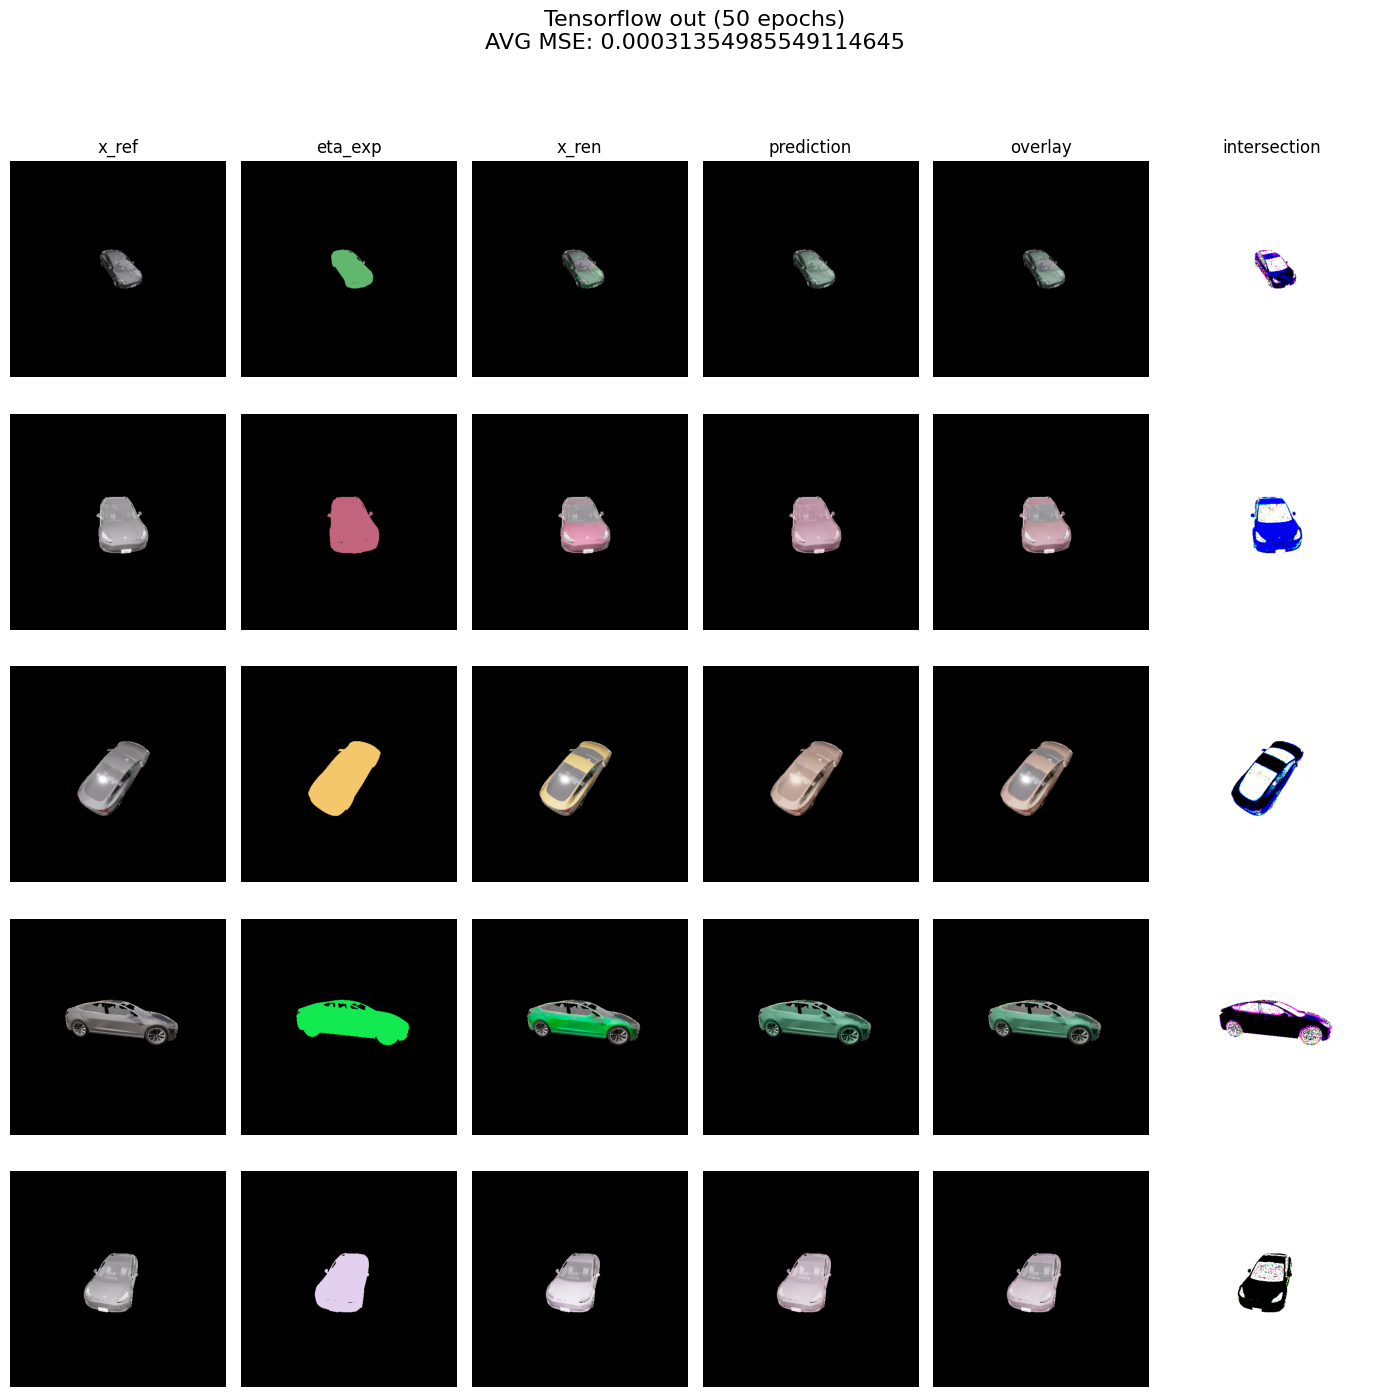

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Predict
preds = model.predict([x_ref[1025:], eta_exp[1025:]])

intersection_mask = np.isclose(x_ren[1025:], x_ref[1025:], atol=1e-2)
overlay_preds = np.where(intersection_mask, x_ref[1025:], preds)

num_samples = 5
titles = ["x_ref", "eta_exp", "x_ren", "prediction", "overlay", "intersection"]

plt.figure(figsize=(14, num_samples * 3))

for i in range(num_samples):
    images = [
        x_ref[i+1025],
        eta_exp[i+1025],
        x_ren[i+1025],
        preds[i],
        overlay_preds[i],
        intersection_mask[i].astype(float)  # Show mask as image
    ]
    for j in range(6):
        plt.subplot(num_samples, 6, i * 6 + j + 1)
        plt.imshow(np.clip(images[j], 0, 1), cmap='gray' if j == 5 else None)
        plt.axis('off')
        if i == 0:
            plt.title(titles[j])

plt.suptitle(f"Tensorflow out (50 epochs)\nAVG MSE: {avg_mse}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## custom loss model (without model.fit())

In [ ]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Concatenate, Flatten, Dense, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
import sklearn
import sklearn.metrics
from PIL import Image



In [ ]:
def build_simple_dtn(input_shape):
    # Inputs
    x_ref_input = Input(shape=input_shape, name='x_ref')
    eta_exp_input = Input(shape=input_shape, name='eta_exp')

    # Combine inputs along channel dimension
    x = Concatenate()([x_ref_input, eta_exp_input])  # Shape: (H, W, 6)

    # structure 1
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # structure 2
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # structure 3
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)


    # structure 4
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # # Crop to match the input shape
    # x = tf.keras.layers.Cropping2D(cropping=((2, 2), (2, 2)))(x)

    # structure 5
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # final layer 
    x = Conv2D(3, (1, 1), activation='sigmoid', padding='same', name='prediction')(x)  # Output 3 channels

    # Create the model
    model = Model(inputs=[x_ref_input, eta_exp_input], outputs=x)

    return model


In [13]:
def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images)


print("Loading real datasets...")
x_ref = load_images_from_folder('dataset/reference')
eta_exp = load_images_from_folder('dataset/texture')
x_ren = load_images_from_folder('dataset/rendered')
print(x_ref.shape)

Loading real datasets...
(1030, 500, 500, 3)


In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

class IntersectionOverlayCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_ref_val, eta_exp_val, x_ren_val, save_dir='overlay_outputs_50_epochs_custom_loop_loss', interval=1):
        super().__init__()
        self.x_ref_val = x_ref_val
        self.eta_exp_val = eta_exp_val
        self.x_ren_val = x_ren_val
        self.interval = interval
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.interval != 0:
            return

        preds = self.model.predict([self.x_ref_val, self.eta_exp_val])


        # Compute intersection (where rendered and reference are nearly equal)
        intersection_mask = np.isclose(self.x_ren_val, self.x_ref_val, atol=1e-2)

        # Overlay: only keep intersecting pixels in prediction
        overlay_preds = np.where(intersection_mask, self.x_ref_val, preds)
        #overlay_preds = np.where(intersection_mask, preds, 0.0)

        # Visualize or save first few samples
        num_samples = min(3, len(preds))
        for i in range(num_samples):
            fig, axes = plt.subplots(1, 4, figsize=(16, 4))
            axes[0].imshow(self.x_ref_val[i])
            axes[0].set_title("x_ref")
            axes[1].imshow(self.x_ren_val[i])
            axes[1].set_title("x_ren")
            axes[2].imshow(preds[i])
            axes[2].set_title("prediction")
            axes[3].imshow(overlay_preds[i])
            axes[3].set_title("pred ∩ intersection")
            for ax in axes:
                ax.axis("off")

            plt.tight_layout()
            plt.savefig(os.path.join(self.save_dir, f"epoch_{epoch+1}_sample_{i+1}.png"))
            plt.close()

In [15]:
def masked_mse_loss(x_ref, x_ren, y_pred, epsilon=1e-2):
    # # Create a mask where x_ref and x_ren are NOT approximately equal
    # mask = tf.abs(x_ren - x_ref) > epsilon
    # mask = tf.cast(mask, tf.float32)

    # # Compute squared error and apply the mask
    # squared_diff = tf.square(y_pred - x_ren)
    # masked_squared_diff = squared_diff * mask
    
    # Create a mask where x_ref and x_ren are approximately equal
    mask = tf.math.less_equal(tf.abs(x_ren - x_ref), epsilon)
    mask = tf.cast(mask, tf.float32)

    # Overlay: only keep intersecting pixels in prediction by substituting with x_ref
    overlay_preds = y_pred * (1 - mask) + x_ref * mask  # Same as np.where(mask, x_ref, y_pred)

    # Compute MSE between x_ren and overlay_preds
    mse = tf.reduce_mean(tf.square(x_ren - overlay_preds))

    return mse

    # Mean over only masked values
    # loss = tf.reduce_sum(masked_squared_diff) / (tf.reduce_sum(mask) + 1e-8)
    # return mse


In [16]:
# Assuming x_ref, eta_exp, and x_ren are loaded with shape (N, H, W, 3)
model = build_simple_dtn(input_shape=(500, 500, 3))

batch_size = 16
epochs = 50

split_idx = int(1025 * 0.9)

x_ref_train = x_ref[:split_idx]
eta_exp_train = eta_exp[:split_idx]
x_ren_train = x_ren[:split_idx]

x_ref_val = x_ref[split_idx:1025]
eta_exp_val = eta_exp[split_idx:1025]
x_ren_val = x_ren[split_idx:1025]

train_dataset = tf.data.Dataset.from_tensor_slices((x_ref_train, eta_exp_train, x_ren_train))
train_dataset = train_dataset.shuffle(1000).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((x_ref_val, eta_exp_val, x_ren_val))
val_dataset = val_dataset.batch(batch_size)


# model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Use a small validation set to visualize overlays
callback = IntersectionOverlayCallback(
    x_ref_val=x_ref[1025:], 
    eta_exp_val=eta_exp[1025:], 
    x_ren_val=x_ren[1025:], 
    save_dir='overlay_outputs_50_epochs_custom_loop_loss', 
    interval=1  # every epoch
)


val_loss = tf.keras.metrics.Mean(name="val_loss")
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name="train_loss")
# Custom training loop

for epoch in range(epochs):
    train_loss.reset_states()
    val_loss.reset_states()

    for x_ref_batch, eta_exp_batch, x_ren_batch in train_dataset:
        with tf.GradientTape() as tape:
            y_pred = model([x_ref_batch, eta_exp_batch], training=True)
            loss = masked_mse_loss(x_ref_batch, x_ren_batch, y_pred)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_loss.update_state(loss)

    # Validation loop
    for x_ref_batch, eta_exp_batch, x_ren_batch in val_dataset:
        y_pred = model([x_ref_batch, eta_exp_batch], training=False)
        loss = masked_mse_loss(x_ref_batch, x_ren_batch, y_pred)
        val_loss.update_state(loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss.result():.6f} - Val Loss: {val_loss.result():.6f}")

    callback.model = model  # Set the model for the callback
    # Call visualization callback
    callback.on_epoch_end(epoch)

model.save('models/k1_50epch_custom_loop_loss_model.h5')
# history = model.fit(
#     [x_ref[:1025], eta_exp[:1025]],
#     x_ren[:1025],
#     epochs=50,
#     batch_size=16,
#     validation_split=0.1,
#     callbacks=[callback]
# )
            # callbacks=[ 
            #     tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
            # ]
        
# early stopping disable for structure 4

Epoch 1/50 - Train Loss: 0.000924 - Val Loss: 0.000552
1/1 [==============================] - 0s 129ms/step
Epoch 2/50 - Train Loss: 0.000228 - Val Loss: 0.000218
1/1 [==============================] - 0s 101ms/step
Epoch 3/50 - Train Loss: 0.000156 - Val Loss: 0.000210
1/1 [==============================] - 0s 105ms/step
Epoch 4/50 - Train Loss: 0.000153 - Val Loss: 0.000213
1/1 [==============================] - 0s 102ms/step
Epoch 5/50 - Train Loss: 0.000148 - Val Loss: 0.000218
1/1 [==============================] - 0s 102ms/step
Epoch 6/50 - Train Loss: 0.000143 - Val Loss: 0.000208
1/1 [==============================] - 0s 102ms/step
Epoch 7/50 - Train Loss: 0.000141 - Val Loss: 0.000206
1/1 [==============================] - 0s 101ms/step
Epoch 8/50 - Train Loss: 0.000139 - Val Loss: 0.000207
1/1 [==============================] - 0s 105ms/step
Epoch 9/50 - Train Loss: 0.000136 - Val Loss: 0.000215
1/1 [==============================] - 0s 101ms/step
Epoch 10/50 - Train Loss: 0.

#### Validation on val_dataset

In [17]:
print("Loading validation datasets...")
val_x_ref = load_images_from_folder('validation_dataset_clean/reference')
val_eta_exp = load_images_from_folder('validation_dataset_clean/texture')
val_x_ren = load_images_from_folder('validation_dataset_clean/rendered')
print(val_x_ref.shape)

Loading validation datasets...
(75, 500, 500, 3)


In [18]:
# Predict
preds = model.predict([val_x_ref, val_eta_exp])
# Compute intersection (where rendered and reference are nearly equal)
intersection_mask = np.isclose(val_x_ren, val_x_ref, atol=1e-2)

# Overlay: only keep intersecting pixels in prediction
overlay_preds = np.where(intersection_mask, val_x_ref, preds)
# overlay_preds = np.where(intersection_mask, preds, 0.0)

avg_mse = sklearn.metrics.mean_squared_error(val_x_ren.ravel(), overlay_preds.ravel())


print("Average MSE: ", avg_mse)  

3/3 [==============================] - 1s 404ms/step
Average MSE:  0.00032804802


1/1 [==============================] - 0s 104ms/step


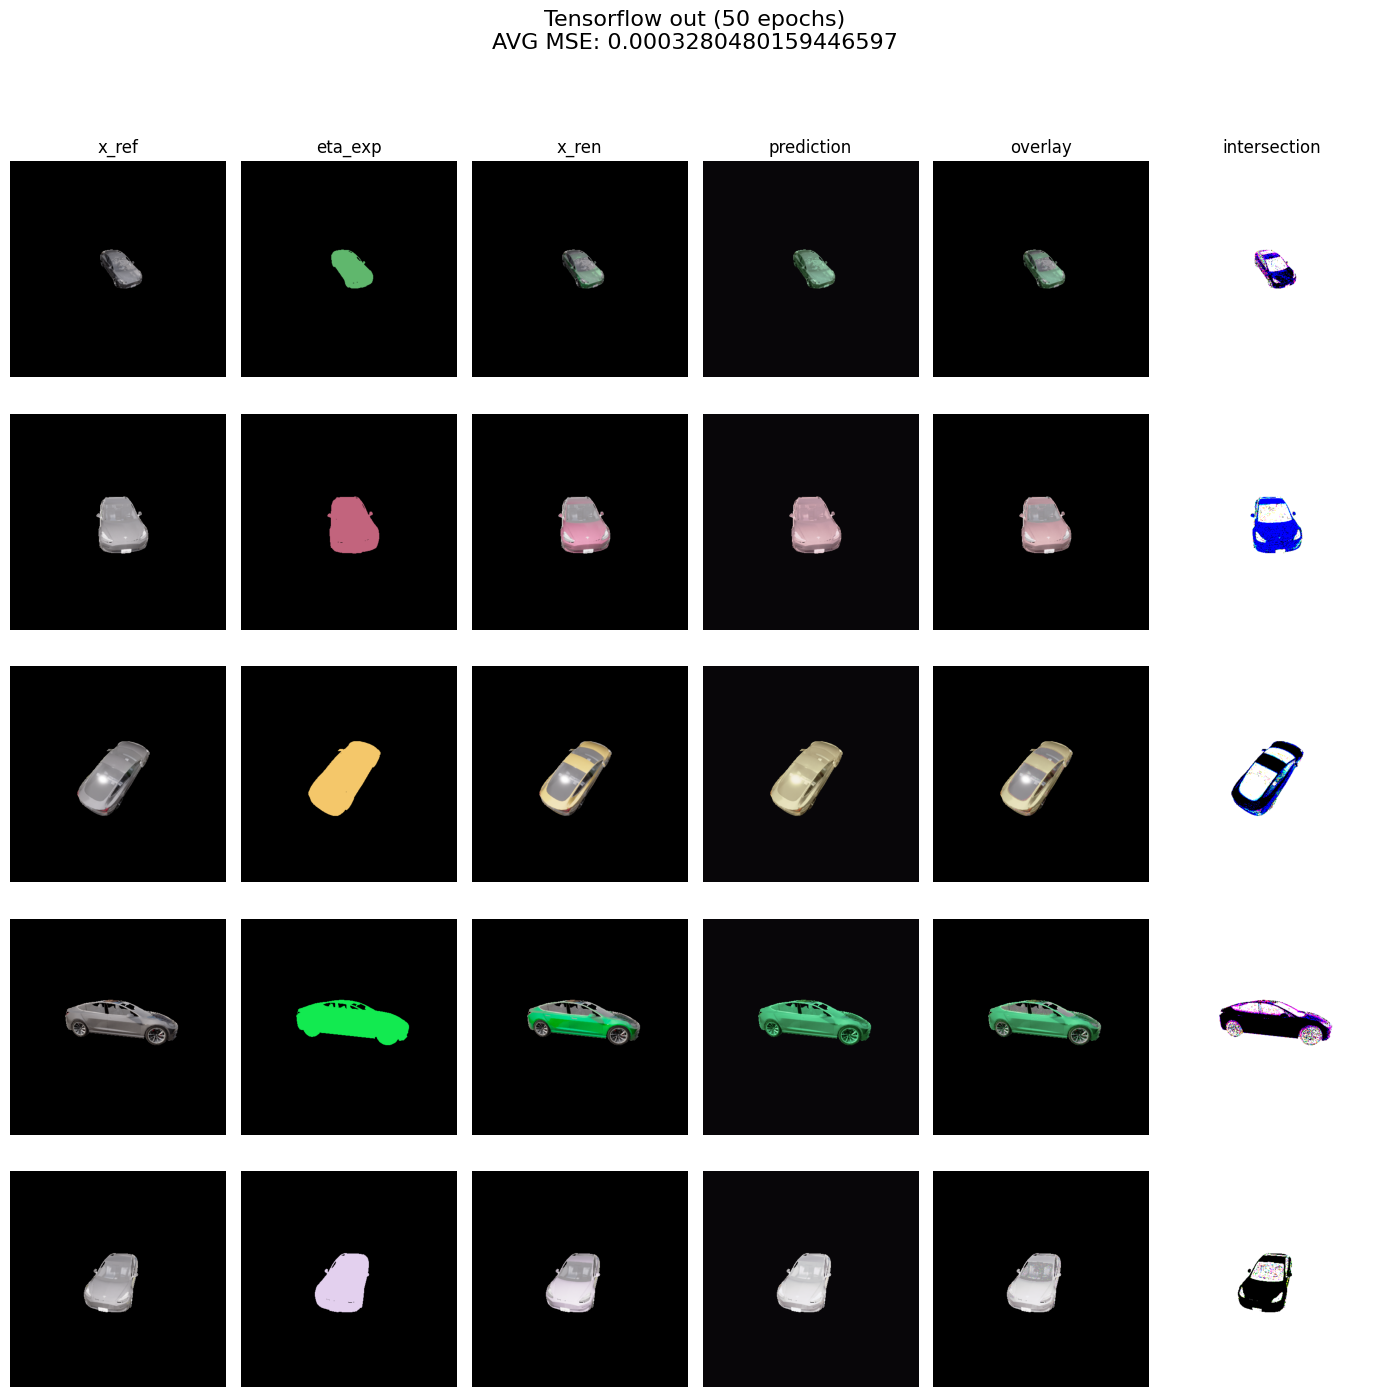

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Predict
preds = model.predict([x_ref[1025:], eta_exp[1025:]])

intersection_mask = np.isclose(x_ren[1025:], x_ref[1025:], atol=1e-2)
overlay_preds = np.where(intersection_mask, x_ref[1025:], preds)

num_samples = 5
titles = ["x_ref", "eta_exp", "x_ren", "prediction", "overlay", "intersection"]

plt.figure(figsize=(14, num_samples * 3))

for i in range(num_samples):
    images = [
        x_ref[i+1025],
        eta_exp[i+1025],
        x_ren[i+1025],
        preds[i],
        overlay_preds[i],
        intersection_mask[i].astype(float)  # Show mask as image
    ]
    for j in range(6):
        plt.subplot(num_samples, 6, i * 6 + j + 1)
        plt.imshow(np.clip(images[j], 0, 1), cmap='gray' if j == 5 else None)
        plt.axis('off')
        if i == 0:
            plt.title(titles[j])

plt.suptitle(f"Tensorflow out (50 epochs)\nAVG MSE: {avg_mse}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## GANs

In [4]:
import tensorflow as tf
from keras import Input, Model
from keras import layers, optimizers
from keras.layers import Conv2D, Concatenate, Flatten, Dense, MaxPooling2D
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
import sklearn
import sklearn.metrics
from PIL import Image



In [2]:
def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images)


print("Loading real datasets...")
x_ref = load_images_from_folder('dataset/reference')
eta_exp = load_images_from_folder('dataset/texture')
x_ren = load_images_from_folder('dataset/rendered')
print(x_ref.shape)

Loading real datasets...
(1030, 500, 500, 3)


In [3]:
import tensorflow as tf
from keras import Input, Model, layers, optimizers
from keras.layers import Conv2D, Concatenate, Flatten, Dense, MaxPooling2D, LeakyReLU
from keras.optimizers import Adam
import numpy as np
import os
from glob import glob

# Generator
def build_generator(input_shape):
    x_ref_input = Input(shape=input_shape, name='x_ref')
    eta_exp_input = Input(shape=input_shape, name='eta_exp')
    x = Concatenate()([x_ref_input, eta_exp_input])  # (H,W,6)

    # Your chosen structure (structure 3)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    out_img = Conv2D(3, (1, 1), activation='sigmoid', padding='same')(x)
    return Model([x_ref_input, eta_exp_input], out_img, name="Generator")

# Discriminator
def build_discriminator(input_shape):
    cond_input1 = Input(shape=input_shape, name='x_ref')
    cond_input2 = Input(shape=input_shape, name='eta_exp')
    img_input = Input(shape=input_shape, name='target_or_generated')

    # Combine condition and image
    x = Concatenate()([cond_input1, cond_input2, img_input])  # (H,W,9)
    x = Conv2D(64, (4, 4), strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(128, (4, 4), strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(256, (4, 4), strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(1, (4, 4), padding='same', activation='sigmoid')(x)  # PatchGAN output

    return Model([cond_input1, cond_input2, img_input], x, name="Discriminator")

# Build models
input_shape = (500, 500, 3)
generator = build_generator(input_shape)
discriminator = build_discriminator(input_shape)

# Compile Discriminator separately
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Combined GAN model (for training Generator)
discriminator.trainable = False
gen_output = generator([generator.inputs[0], generator.inputs[1]])
validity = discriminator([generator.inputs[0], generator.inputs[1], gen_output])
gan = Model(generator.inputs, [gen_output, validity])

# Loss weights: L1 + adversarial
lambda_l1 = 100
def combined_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred)) * lambda_l1

gan.compile(
    loss=[combined_loss, 'binary_crossentropy'],
    loss_weights=[1, 1],
    optimizer=Adam(0.0002, 0.5)
)


# Train
batch_size = 4
epochs = 50
valid = np.ones((batch_size, 63, 63, 1))  # Patch size will depend on image size
fake = np.zeros((batch_size, 63, 63, 1))

for epoch in range(epochs):
    for i in range(len(x_ref) // batch_size):
        idx = np.random.randint(0, x_ref.shape[0], batch_size)
        ref_batch = x_ref[idx]
        tex_batch = eta_exp[idx]
        real_batch = x_ren[idx]

        # Generate images
        gen_imgs = generator.predict([ref_batch, tex_batch])

        # Train Discriminator
        # d_loss_real = discriminator.train_on_batch([ref_batch, tex_batch, real_batch], valid)

        d_loss_real = discriminator.train_on_batch(
            {"x_ref": ref_batch, "eta_exp": tex_batch, "target_or_generated": real_batch},
            valid
        )

        # d_loss_fake = discriminator.train_on_batch([ref_batch, tex_batch, gen_imgs], fake)
        d_loss_fake = discriminator.train_on_batch(
            {"x_ref": ref_batch, "eta_exp": tex_batch, "target_or_generated": gen_imgs},
            fake
        )

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        # g_loss = gan.train_on_batch([ref_batch, tex_batch], [real_batch, valid])
        g_loss = gan.train_on_batch(
            {"x_ref": ref_batch, "eta_exp": tex_batch},
            [real_batch, valid]
        )

    print(f"{epoch+1}/{epochs}  D loss: {d_loss[0]:.4f}, acc: {d_loss[1]*100:.2f}% | G loss: {g_loss}")

# Save models
generator.save('models/gan_generator.h5')
discriminator.save('models/gan_discriminator.h5')

c:\Users\bz0192\.conda\envs\PROJECT2\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['x_ref', 'eta_exp']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


c:\Users\bz0192\.conda\envs\PROJECT2\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['x_ref', 'eta_exp', 'target_or_generated']. Received: the structure of inputs={'x_ref': '*', 'eta_exp': '*', 'target_or_generated': '*'}
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'update_state'

In [2]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam
import numpy as np

# ---------------------------
# Generator
# ---------------------------
def build_generator(input_shape):
    x_ref_input = Input(shape=input_shape, name='x_ref')
    eta_exp_input = Input(shape=input_shape, name='eta_exp')
    x = Concatenate()([x_ref_input, eta_exp_input])  # (H,W,6)

    x = Conv2D(32,  (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64,  (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64,  (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32,  (3, 3), activation='relu', padding='same')(x)

    out_img = Conv2D(3, (1, 1), activation='sigmoid', padding='same', name='gen_out')(x)
    return Model([x_ref_input, eta_exp_input], out_img, name="Generator")

# ---------------------------
# Discriminator (PatchGAN)
# ---------------------------
def build_discriminator(input_shape):
    x_ref_in = Input(shape=input_shape, name='x_ref')
    eta_in   = Input(shape=input_shape, name='eta_exp')
    img_in   = Input(shape=input_shape, name='target_or_generated')

    x = Concatenate()([x_ref_in, eta_in, img_in])  # (H,W,9)
    x = Conv2D(64,  (4, 4), strides=2, padding='same')(x);  x = LeakyReLU(0.2)(x)
    x = Conv2D(128, (4, 4), strides=2, padding='same')(x);  x = LeakyReLU(0.2)(x)
    x = Conv2D(256, (4, 4), strides=2, padding='same')(x);  x = LeakyReLU(0.2)(x)
    out = Conv2D(1,   (4, 4), padding='same', activation='sigmoid', name='disc_out')(x)
    return Model([x_ref_in, eta_in, img_in], out, name="Discriminator")

# ---------------------------
# Build
# ---------------------------
input_shape = (500, 500, 3)
G = build_generator(input_shape)
D = build_discriminator(input_shape)

# Discriminator compile (no extra metrics to avoid update_state quirks)
D.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5)
)

# Combined model for training G
D.trainable = False
gen_img = G({'x_ref': G.inputs[0], 'eta_exp': G.inputs[1]})
validity = D({'x_ref': G.inputs[0], 'eta_exp': G.inputs[1], 'target_or_generated': gen_img})

lambda_l1 = 100.0
def l1_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred)) * lambda_l1

GAN = Model(G.inputs, [gen_img, validity], name='GAN')
GAN.compile(
    loss=[l1_loss, 'binary_crossentropy'],
    loss_weights=[1.0, 1.0],
    optimizer=Adam(0.0002, 0.5)
)

# ---------------------------
# Training loop (expects x_ref, eta_exp, x_ren already loaded as float32 in [0,1])
# ---------------------------
batch_size = 4
epochs = 50

num_batches = x_ref.shape[0] // batch_size

# Compute patch label shape dynamically
tmp_y = D({
    'x_ref': x_ref[:batch_size],
    'eta_exp': eta_exp[:batch_size],
    'target_or_generated': x_ren[:batch_size]
}, training=False)
patch_shape = tmp_y.shape[1:]             # e.g., (63, 63, 1)
valid = np.ones((batch_size,) + tuple(patch_shape), dtype=np.float32)
fake  = np.zeros((batch_size,) + tuple(patch_shape), dtype=np.float32)

for epoch in range(epochs):
    for _ in range(num_batches):
        idx = np.random.randint(0, x_ref.shape[0], batch_size)
        ref_b = x_ref[idx]
        tex_b = eta_exp[idx]
        real_b = x_ren[idx]

        # -----------------------
        # Train D
        # -----------------------
        # Generate fakes (forward pass only)
        gen_b = G({'x_ref': ref_b, 'eta_exp': tex_b}, training=True)

        D.trainable = True
        d_loss_real = D.train_on_batch(
            {'x_ref': ref_b, 'eta_exp': tex_b, 'target_or_generated': real_b},
            valid
        )
        d_loss_fake = D.train_on_batch(
            {'x_ref': ref_b, 'eta_exp': tex_b, 'target_or_generated': gen_b},
            fake
        )
        # d_loss may be a scalar or [loss] depending on Keras version
        d_loss = 0.5 * (float(np.atleast_1d(d_loss_real)[0]) + float(np.atleast_1d(d_loss_fake)[0]))

        # -----------------------
        # Train G (adversarial + L1)
        # -----------------------
        D.trainable = False
        g_losses = GAN.train_on_batch(
            {'x_ref': ref_b, 'eta_exp': tex_b},
            [real_b, valid]
        )
        # g_losses is [total, l1, adv] or similar depending on version; show total
        g_loss_total = float(np.atleast_1d(g_losses)[0])

    print(f"{epoch+1}/{epochs}  D loss: {d_loss:.4f} | G loss: {g_loss_total:.4f}")

# Save
G.save('models/gan_generator.h5')
D.save('models/gan_discriminator.h5')


ModuleNotFoundError: No module named 'tensorflow.keras'

In [4]:
import tensorflow as tf
from keras import Input, Model
from keras.layers import Conv2D, Concatenate, LeakyReLU
from keras.optimizers import Adam

# Generator
def build_generator():
    inp = Input(shape=(64, 64, 3))
    x = Conv2D(64, kernel_size=3, strides=1, padding="same")(inp)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(3, kernel_size=3, strides=1, padding="same", activation="tanh")(x)
    return Model(inp, x, name="Generator")

# Discriminator
def build_discriminator():
    inp = Input(shape=(64, 64, 3))
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(inp)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(1, kernel_size=3, strides=1, padding="same")(x)
    return Model(inp, x, name="Discriminator")

# Optimizers
gen_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
disc_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

# Build models
generator = build_generator()
discriminator = build_discriminator()

# Compile discriminator
discriminator.compile(
    loss="binary_crossentropy", optimizer=disc_optimizer, metrics=["accuracy"]
)

# GAN model (discriminator not trainable in combined model)
discriminator.trainable = False
gan_input = Input(shape=(64, 64, 3))
fake_img = generator(gan_input)
gan_output = discriminator(fake_img)
gan = Model(gan_input, gan_output, name="GAN")
gan.compile(loss="binary_crossentropy", optimizer=gen_optimizer)

print(generator.summary())
print(discriminator.summary())
print(gan.summary())


c:\Users\bz0192\.conda\envs\PROJECT2\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 64, 64, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,523 (13.76 KB)

 Trainable params: 3,523 (13.76 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 16, 16, 1)      │         1,153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,801 (300.00 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 76,801 (300.00 KB)

None


Model: "GAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Generator (Functional)          │ (None, 64, 64, 3)      │         3,523 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator (Functional)      │ (None, 16, 16, 1)      │        76,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,324 (313.77 KB)

 Trainable params: 3,523 (13.76 KB)

 Non-trainable params: 76,801 (300.00 KB)

None


In [5]:
import os
import numpy as np
import tensorflow as tf
from keras import Input, Model
from keras.layers import Conv2D, Concatenate, LeakyReLU, Dense, Flatten, Reshape
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# -------------------
#  Generator
# -------------------
def build_generator():
    inp = Input(shape=(100,))  # random noise vector
    x = Dense(8*8*128)(inp)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((8, 8, 128))(x)
    x = Conv2D(128, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.UpSampling2D()(x)
    x = Conv2D(3, kernel_size=3, strides=1, padding="same", activation="tanh")(x)
    return Model(inp, x, name="Generator")

# -------------------
#  Discriminator
# -------------------
def build_discriminator():
    inp = Input(shape=(32, 32, 3))  # use 32x32 if that's your dataset size
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(inp)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    x = Dense(1, activation="sigmoid")(x)
    return Model(inp, x, name="Discriminator")

# -------------------
#  Setup
# -------------------
gen_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
disc_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(loss="binary_crossentropy",
                      optimizer=disc_optimizer,
                      metrics=["accuracy"])

# GAN model
discriminator.trainable = False
z = Input(shape=(100,))
img = generator(z)
validity = discriminator(img)
gan = Model(z, validity)
gan.compile(loss="binary_crossentropy", optimizer=gen_optimizer)

# -------------------
#  Training Loop
# -------------------
def train_gan(epochs=10000, batch_size=64, save_interval=1000):
    # Load your dataset here (example: random noise as placeholder)
    # Replace this with your real dataset (normalized to [-1,1])
    (X_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
    X_train = X_train.astype(np.float32) / 127.5 - 1.0  # scale to [-1,1]
    X_train = X_train.reshape((-1, 32, 32, 3))

    half_batch = batch_size // 2

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        real_imgs = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_imgs = generator.predict(noise, verbose=0)

        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))  # want discriminator to think fakes are real
        g_loss = gan.train_on_batch(noise, valid_y)

        # Print progress
        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")

        # Save generated images
        if epoch % save_interval == 0:
            save_images(epoch, generator)

# -------------------
#  Save Images
# -------------------
def save_images(epoch, generator, examples=16):
    noise = np.random.normal(0, 1, (examples, 100))
    gen_imgs = generator.predict(noise, verbose=0)
    gen_imgs = 0.5 * gen_imgs + 0.5  # rescale [0,1]

    fig, axs = plt.subplots(4, 4, figsize=(6,6))
    cnt = 0
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i,j].axis('off')
            cnt += 1
    os.makedirs("gan_images", exist_ok=True)
    fig.savefig(f"gan_images/{epoch}.png")
    plt.close()

# -------------------
#  Run Training
# -------------------
train_gan(epochs=5000, batch_size=64, save_interval=1000)


c:\Users\bz0192\.conda\envs\PROJECT2\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


AttributeError: 'NoneType' object has no attribute 'update_state'

In [7]:
import os
import numpy as np
import tensorflow as tf
from glob import glob
from keras import Input, Model, layers, optimizers, preprocessing
from keras.layers import Conv2D, Concatenate, LeakyReLU
from keras.optimizers import Adam
from keras.preprocessing.image import load_img, img_to_array

# -----------------------
# DATA LOADING
# -----------------------
def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = load_img(path, target_size=image_size)
        img = img_to_array(img)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images)

print("Loading datasets...")
x_ref = load_images_from_folder('dataset/reference')
eta_exp = load_images_from_folder('dataset/texture')
x_ren = load_images_from_folder('dataset/rendered')

print("Reference shape:", x_ref.shape)
print("Texture shape:", eta_exp.shape)
print("Rendered shape:", x_ren.shape)

assert x_ref.shape == eta_exp.shape == x_ren.shape, "Dataset mismatch! Check folder sizes or images."

# -----------------------
# MODELS (dummy example)
# -----------------------
def build_generator(img_shape):
    ref_in = Input(shape=img_shape)
    tex_in = Input(shape=img_shape)

    x = Concatenate()([ref_in, tex_in])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    out = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    return Model([ref_in, tex_in], out, name="Generator")

def build_discriminator(img_shape):
    ref_in = Input(shape=img_shape)
    tex_in = Input(shape=img_shape)
    ren_in = Input(shape=img_shape)

    x = Concatenate()([ref_in, tex_in, ren_in])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    out = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return Model([ref_in, tex_in, ren_in], out, name="Discriminator")

img_shape = x_ref.shape[1:]  # (500, 500, 3)
generator = build_generator(img_shape)
discriminator = build_discriminator(img_shape)

# Compile discriminator
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss="binary_crossentropy", metrics=["accuracy"])

# -----------------------
# COMBINED MODEL (GAN)
# -----------------------
ref_in = Input(shape=img_shape)
tex_in = Input(shape=img_shape)
fake_ren = generator([ref_in, tex_in])
discriminator.trainable = False
validity = discriminator([ref_in, tex_in, fake_ren])

combined = Model([ref_in, tex_in], validity)
combined.compile(optimizer=Adam(0.0002, 0.5), loss="binary_crossentropy")

# -----------------------
# TRAINING LOOP
# -----------------------
epochs = 100
batch_size = 8

valid = np.ones((batch_size,) + (img_shape[0], img_shape[1], 1))
fake = np.zeros((batch_size,) + (img_shape[0], img_shape[1], 1))

for epoch in range(epochs):
    idx = np.random.randint(0, x_ref.shape[0], batch_size)
    ref_batch = x_ref[idx]
    tex_batch = eta_exp[idx]
    real_batch = x_ren[idx]

    # Generate fake rendered images
    gen_imgs = generator.predict([ref_batch, tex_batch])

    # Train discriminator
    d_loss_real = discriminator.train_on_batch([ref_batch, tex_batch, real_batch], valid)
    d_loss_fake = discriminator.train_on_batch([ref_batch, tex_batch, gen_imgs], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    g_loss = combined.train_on_batch([ref_batch, tex_batch], valid)

    print(f"{epoch+1}/{epochs} [D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}] [G loss: {g_loss:.4f}]")


Loading datasets...
Reference shape: (1030, 500, 500, 3)
Texture shape: (1030, 500, 500, 3)
Rendered shape: (1030, 500, 500, 3)


c:\Users\bz0192\.conda\envs\PROJECT2\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\bz0192\.conda\envs\PROJECT2\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_68', 'keras_tensor_69']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


AttributeError: 'NoneType' object has no attribute 'update_state'

In [10]:
import os
import numpy as np
import tensorflow as tf
from glob import glob
from keras import Input, Model, layers, optimizers
from keras.layers import Conv2D, Concatenate, LeakyReLU
from keras.optimizers import Adam
from keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt

# -----------------------
# DATA LOADING
# -----------------------
def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = load_img(path, target_size=image_size)
        img = img_to_array(img)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images)

print("Loading datasets...")
x_ref = load_images_from_folder('dataset/reference')
eta_exp = load_images_from_folder('dataset/texture')
x_ren = load_images_from_folder('dataset/rendered')

print("Reference shape:", x_ref.shape)
print("Texture shape:", eta_exp.shape)
print("Rendered shape:", x_ren.shape)

# -----------------------
# MODEL DEFINITIONS
# -----------------------

img_shape = x_ref.shape[1:]  # (500, 500, 3)

# Generator
def build_generator(img_shape):
    ref_in = Input(shape=img_shape, name="ref_input")
    tex_in = Input(shape=img_shape, name="tex_input")
    x = Concatenate()([ref_in, tex_in])
    x = Conv2D(64, (3,3), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    out = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)
    return Model([ref_in, tex_in], out, name="Generator")

# Discriminator
def build_discriminator(img_shape):
    ref_in = Input(shape=img_shape, name="ref_input")
    tex_in = Input(shape=img_shape, name="tex_input")
    ren_in = Input(shape=img_shape, name="ren_input")
    x = Concatenate()([ref_in, tex_in, ren_in])
    x = Conv2D(64, (3,3), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    out = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
    return Model([ref_in, tex_in, ren_in], out, name="Discriminator")

# Build models
generator = build_generator(img_shape)
discriminator = build_discriminator(img_shape)

# Compile discriminator
disc_optimizer = Adam(0.0002, 0.5)
discriminator.compile(loss="binary_crossentropy", optimizer=disc_optimizer, metrics=["accuracy"])

# Combined GAN
ref_input = Input(shape=img_shape, name="ref_input")
tex_input = Input(shape=img_shape, name="tex_input")
fake_ren = generator([ref_input, tex_input])
discriminator.trainable = False
validity = discriminator([ref_input, tex_input, fake_ren])
gan = Model([ref_input, tex_input], validity)
gan.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5))

# -----------------------
# TRAINING LOOP
# -----------------------
epochs = 100
batch_size = 4

# Match discriminator output shape
valid = np.ones((batch_size, img_shape[0], img_shape[1], 1), dtype=np.float32)
fake = np.zeros((batch_size, img_shape[0], img_shape[1], 1), dtype=np.float32)

for epoch in range(epochs):
    # Random batch selection
    idx = np.random.randint(0, x_ref.shape[0], batch_size)
    ref_batch = x_ref[idx]
    tex_batch = eta_exp[idx]
    real_batch = x_ren[idx]

    # Generate fake images
    gen_imgs = generator.predict([ref_batch, tex_batch], verbose=0)

    # Train Discriminator (use list, not dict!)
    d_loss_real = discriminator.train_on_batch([ref_batch, tex_batch, real_batch], valid)
    d_loss_fake = discriminator.train_on_batch([ref_batch, tex_batch, gen_imgs], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator via GAN (use list)
    g_loss = gan.train_on_batch([ref_batch, tex_batch], valid)

    print(f"{epoch+1}/{epochs} [D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}] [G loss: {g_loss:.4f}]")

# -----------------------
# OPTIONAL: Save models
# -----------------------
generator.save("models/gan_generator.h5")
discriminator.save("models/gan_discriminator.h5")


Loading datasets...
Reference shape: (1030, 500, 500, 3)
Texture shape: (1030, 500, 500, 3)
Rendered shape: (1030, 500, 500, 3)


AttributeError: 'NoneType' object has no attribute 'update_state'

In [11]:
import os
import numpy as np
import tensorflow as tf
from glob import glob
from keras import Input, Model
from keras.layers import Conv2D, Concatenate, LeakyReLU, Flatten, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# -----------------------
#  DATA LOADING
# -----------------------
def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = load_img(path, target_size=image_size)
        img = img_to_array(img) / 255.0  # normalize to [0,1]
        images.append(img)
    return np.array(images, dtype=np.float32)

print("Loading datasets...")
x_ref = load_images_from_folder('dataset/reference')
eta_exp = load_images_from_folder('dataset/texture')
x_ren = load_images_from_folder('dataset/rendered')

print("Reference shape:", x_ref.shape)
print("Texture shape:", eta_exp.shape)
print("Rendered shape:", x_ren.shape)

img_shape = x_ref.shape[1:]  # (500,500,3)

# -----------------------
#  GENERATOR
# -----------------------
def build_generator(img_shape):
    ref_in = Input(shape=img_shape)
    tex_in = Input(shape=img_shape)
    x = Concatenate()([ref_in, tex_in])
    x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)
    return Model([ref_in, tex_in], x, name="Generator")

# -----------------------
#  DISCRIMINATOR
# -----------------------
def build_discriminator(img_shape):
    ref_in = Input(shape=img_shape)
    tex_in = Input(shape=img_shape)
    ren_in = Input(shape=img_shape)
    x = Concatenate()([ref_in, tex_in, ren_in])
    x = Conv2D(64, (3,3), strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(128, (3,3), strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(256, (3,3), strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)  # scalar output
    return Model([ref_in, tex_in, ren_in], out, name="Discriminator")

# -----------------------
#  BUILD MODELS
# -----------------------
generator = build_generator(img_shape)
discriminator = build_discriminator(img_shape)

disc_optimizer = Adam(0.0002, 0.5)
gen_optimizer = Adam(0.0002, 0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer, metrics=['accuracy'])

# GAN
ref_input = Input(shape=img_shape)
tex_input = Input(shape=img_shape)
fake_ren = generator([ref_input, tex_input])
discriminator.trainable = False
validity = discriminator([ref_input, tex_input, fake_ren])
gan = Model([ref_input, tex_input], validity)
gan.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

# -----------------------
#  TRAINING LOOP
# -----------------------
epochs = 100
batch_size = 4

valid = np.ones((batch_size,1), dtype=np.float32)
fake  = np.zeros((batch_size,1), dtype=np.float32)

for epoch in range(epochs):
    # Random batch
    idx = np.random.randint(0, x_ref.shape[0], batch_size)
    ref_batch = x_ref[idx]
    tex_batch = eta_exp[idx]
    real_batch = x_ren[idx]

    # Generate fake images
    gen_imgs = generator.predict([ref_batch, tex_batch], verbose=0)

    # Train discriminator
    d_loss_real = discriminator.train_on_batch([ref_batch, tex_batch, real_batch], valid)
    d_loss_fake = discriminator.train_on_batch([ref_batch, tex_batch, gen_imgs], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator via GAN
    g_loss = gan.train_on_batch([ref_batch, tex_batch], valid)

    print(f"{epoch+1}/{epochs} [D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}] [G loss: {g_loss:.4f}]")

# -----------------------
#  SAVE MODELS
# -----------------------
os.makedirs("models", exist_ok=True)
generator.save("models/gan_generator.h5")
discriminator.save("models/gan_discriminator.h5")


Loading datasets...
Reference shape: (1030, 500, 500, 3)
Texture shape: (1030, 500, 500, 3)
Rendered shape: (1030, 500, 500, 3)


c:\Users\bz0192\.conda\envs\PROJECT2\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_105', 'keras_tensor_106']. Received: the structure of inputs=('*', '*')
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'update_state'

In [12]:
import os
import numpy as np
import tensorflow as tf
from glob import glob
from keras import Input, Model
from keras.layers import Conv2D, Concatenate, LeakyReLU, Flatten, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import load_img, img_to_array

# -----------------------
# DATA LOADING
# -----------------------
def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = load_img(path, target_size=image_size)
        img = img_to_array(img)
        img = img / 255.0  # normalize [0,1]
        images.append(img)
    return np.array(images, dtype=np.float32)

print("Loading datasets...")
x_ref = load_images_from_folder('dataset/reference')
eta_exp = load_images_from_folder('dataset/texture')
x_ren = load_images_from_folder('dataset/rendered')

print("Reference shape:", x_ref.shape)
print("Texture shape:", eta_exp.shape)
print("Rendered shape:", x_ren.shape)

img_shape = x_ref.shape[1:]  # (500,500,3)

# -----------------------
# GENERATOR
# -----------------------
def build_generator(img_shape):
    ref_in = Input(shape=img_shape)
    tex_in = Input(shape=img_shape)
    x = Concatenate()([ref_in, tex_in])
    x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
    out = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)
    return Model([ref_in, tex_in], out, name="Generator")

# -----------------------
# PATCHGAN DISCRIMINATOR
# -----------------------
def build_discriminator(img_shape):
    ref_in = Input(shape=img_shape)
    tex_in = Input(shape=img_shape)
    ren_in = Input(shape=img_shape)
    x = Concatenate()([ref_in, tex_in, ren_in])  # shape (500,500,9)

    # PatchGAN layers
    x = Conv2D(64, (4,4), strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(128, (4,4), strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(256, (4,4), strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(1, (4,4), padding='same', activation='sigmoid')(x)  # Patch output
    return Model([ref_in, tex_in, ren_in], x, name="Discriminator")

# -----------------------
# BUILD MODELS
# -----------------------
generator = build_generator(img_shape)
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5), metrics=['accuracy'])

# Combined GAN
ref_input = Input(shape=img_shape)
tex_input = Input(shape=img_shape)
fake_ren = generator([ref_input, tex_input])
discriminator.trainable = False
validity = discriminator([ref_input, tex_input, fake_ren])
gan = Model([ref_input, tex_input], validity)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))

# -----------------------
# TRAINING LOOP
# -----------------------
epochs = 50
batch_size = 4

# PatchGAN output shape
patch_shape = discriminator.output_shape[1:]  # e.g., (63,63,1)
valid = np.ones((batch_size, *patch_shape), dtype=np.float32)
fake = np.zeros((batch_size, *patch_shape), dtype=np.float32)

for epoch in range(epochs):
    idx = np.random.randint(0, x_ref.shape[0], batch_size)
    ref_batch = x_ref[idx]
    tex_batch = eta_exp[idx]
    real_batch = x_ren[idx]

    # Generate fake images
    gen_imgs = generator.predict([ref_batch, tex_batch], verbose=0)

    # Train Discriminator
    d_loss_real = discriminator.train_on_batch([ref_batch, tex_batch, real_batch], valid)
    d_loss_fake = discriminator.train_on_batch([ref_batch, tex_batch, gen_imgs], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator via GAN
    g_loss = gan.train_on_batch([ref_batch, tex_batch], valid)

    print(f"{epoch+1}/{epochs} [D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}] [G loss: {g_loss:.4f}]")

# -----------------------
# SAVE MODELS
# -----------------------
os.makedirs("models", exist_ok=True)
generator.save("models/gan_generator.h5")
discriminator.save("models/gan_discriminator.h5")


Loading datasets...
Reference shape: (1030, 500, 500, 3)
Texture shape: (1030, 500, 500, 3)
Rendered shape: (1030, 500, 500, 3)


c:\Users\bz0192\.conda\envs\PROJECT2\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_127', 'keras_tensor_128']. Received: the structure of inputs=('*', '*')
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'update_state'

In [2]:
import os
import numpy as np
import tensorflow as tf
from glob import glob
from keras import Input, Model
from keras.layers import Conv2D, Concatenate, LeakyReLU
from keras.optimizers import Adam
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# -----------------------
# DATA LOADING
# -----------------------
def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = load_img(path, target_size=image_size)
        img = img_to_array(img) / 255.0  # Normalize
        images.append(img)
    return np.array(images)

print("Loading datasets...")
x_ref = load_images_from_folder('dataset/reference')
eta_exp = load_images_from_folder('dataset/texture')
x_ren = load_images_from_folder('dataset/rendered')

print("Reference shape:", x_ref.shape)
print("Texture shape:", eta_exp.shape)
print("Rendered shape:", x_ren.shape)

# -----------------------
# MODEL DEFINITIONS
# -----------------------
img_shape = x_ref.shape[1:]  # (500, 500, 3)

# Generator
def build_generator(img_shape):
    ref_in = Input(shape=img_shape)
    tex_in = Input(shape=img_shape)
    x = Concatenate()([ref_in, tex_in])
    x = Conv2D(64, (3,3), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    out = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)
    return Model([ref_in, tex_in], out, name="Generator")

# Discriminator
def build_discriminator(img_shape):
    ref_in = Input(shape=img_shape)
    tex_in = Input(shape=img_shape)
    ren_in = Input(shape=img_shape)
    x = Concatenate()([ref_in, tex_in, ren_in])
    x = Conv2D(64, (3,3), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    out = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
    return Model([ref_in, tex_in, ren_in], out, name="Discriminator")

# Build models
generator = build_generator(img_shape)
discriminator = build_discriminator(img_shape)

# -----------------------
# COMPILE DISCRIMINATOR
# -----------------------
disc_optimizer = Adam(0.0002, 0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer)

# -----------------------
# COMBINE INTO GAN
# -----------------------
ref_input = Input(shape=img_shape)
tex_input = Input(shape=img_shape)
fake_ren = generator([ref_input, tex_input])
discriminator.trainable = False
validity = discriminator([ref_input, tex_input, fake_ren])
gan = Model([ref_input, tex_input], validity)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# -----------------------
# TRAINING LOOP
# -----------------------
epochs = 100
batch_size = 4

# Adjust discriminator target to output shape
valid = np.ones((batch_size, img_shape[0], img_shape[1], 1), dtype=np.float32)
fake = np.zeros((batch_size, img_shape[0], img_shape[1], 1), dtype=np.float32)

for epoch in range(epochs):
    idx = np.random.randint(0, x_ref.shape[0], batch_size)
    ref_batch = x_ref[idx]
    tex_batch = eta_exp[idx]
    real_batch = x_ren[idx]

    # Generate fake images
    gen_imgs = generator.predict([ref_batch, tex_batch], verbose=0)

    # --- Train Discriminator ---
    d_loss_real = discriminator.train_on_batch([ref_batch, tex_batch, real_batch], valid)
    d_loss_fake = discriminator.train_on_batch([ref_batch, tex_batch, gen_imgs], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # --- Train Generator ---
    g_loss = gan.train_on_batch([ref_batch, tex_batch], valid)

    #print(f"{epoch+1}/{epochs} [D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}] [G loss: {g_loss:.4f}]")

# -----------------------
# SAVE MODELS
# -----------------------
os.makedirs("models", exist_ok=True)
generator.save("models/gan_generator.h5")
discriminator.save("models/gan_discriminator.h5")


Loading datasets...
Reference shape: (1030, 500, 500, 3)
Texture shape: (1030, 500, 500, 3)
Rendered shape: (1030, 500, 500, 3)


c:\Users\bz0192\.conda\envs\PROJECT2\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_17', 'keras_tensor_18']. Received: the structure of inputs=('*', '*')
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'update_state'

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
from glob import glob
from keras.preprocessing.image import load_img, img_to_array
from IPython import display

# -----------------------
# LOAD DATA
# -----------------------
def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = load_img(path, target_size=image_size)
        img = img_to_array(img) / 127.5 - 1.0  # Normalize to [-1,1]
        images.append(img)
    return np.array(images, dtype=np.float32)

print("Loading datasets...")
x_ref = load_images_from_folder('dataset/reference')
eta_exp = load_images_from_folder('dataset/texture')
x_ren = load_images_from_folder('dataset/rendered')

print("Reference shape:", x_ref.shape)
print("Texture shape:", eta_exp.shape)
print("Rendered shape:", x_ren.shape)

# -----------------------
# CREATE DATASET
# -----------------------
BATCH_SIZE = 4
BUFFER_SIZE = x_ref.shape[0]

# Combine ref + texture as conditional input
cond_input = np.concatenate([x_ref, eta_exp], axis=-1)  # shape: (N, 500, 500, 6)
train_dataset = tf.data.Dataset.from_tensor_slices((cond_input, x_ren)) \
                               .shuffle(BUFFER_SIZE) \
                               .batch(BATCH_SIZE)

# -----------------------
# GENERATOR
# -----------------------
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(500, 500, 6)))  # conditional input: ref + texture
    model.add(layers.Conv2D(64, (5,5), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(128, (5,5), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(64, (5,5), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(3, (5,5), activation='tanh', padding='same'))  # output: RGB
    return model

generator = make_generator_model()

# -----------------------
# DISCRIMINATOR
# -----------------------
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(500, 500, 9)))  # ref + texture + rendered
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

discriminator = make_discriminator_model()

# -----------------------
# LOSS & OPTIMIZERS
# -----------------------
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# -----------------------
# TRAIN STEP
# -----------------------
@tf.function
def train_step(cond_images, real_images):
    # cond_images: concatenated reference + texture (B, 500,500,6)
    # real_images: rendered images (B,500,500,3)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(cond_images, training=True)

        # Discriminator sees concatenated cond + real/fake
        real_input = tf.concat([cond_images, real_images], axis=-1)
        fake_input = tf.concat([cond_images, generated_images], axis=-1)

        real_output = discriminator(real_input, training=True)
        fake_output = discriminator(fake_input, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# -----------------------
# GENERATE & SAVE
# -----------------------
def generate_and_save_images(model, cond_input, epoch):
    generated_images = model(cond_input, training=False)
    fig = plt.figure(figsize=(4,4))

    for i in range(min(16, generated_images.shape[0])):
        plt.subplot(4,4,i+1)
        img = (generated_images[i] + 1.0) / 2.0  # [-1,1] -> [0,1]
        plt.imshow(img)
        plt.axis('off')
    plt.savefig('gan/100epch/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# -----------------------
# TRAIN LOOP
# -----------------------
EPOCHS = 100

for epoch in range(EPOCHS):
    start = time.time()

    for cond_batch, real_batch in train_dataset:
        g_loss, d_loss = train_step(cond_batch, real_batch)

    display.clear_output(wait=True)
    # Pick a small seed batch for visualization
    seed_cond = cond_input[:16]
    generate_and_save_images(generator, seed_cond, epoch+1)

    print(f"Epoch {epoch+1}, G loss: {g_loss:.4f}, D loss: {d_loss:.4f}, time: {time.time()-start:.2f}s")


Loading datasets...
Reference shape: (1030, 500, 500, 3)
Texture shape: (1030, 500, 500, 3)
Rendered shape: (1030, 500, 500, 3)


KeyboardInterrupt: 